# 1. Reading the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "/content/drive/MyDrive/kaggle_dataset_images.zip" -d "/content/drive/MyDrive/kaggle_dataset_images"

In [5]:
import glob
len(glob.glob1("/content/drive/MyDrive/kaggle_dataset_images/utkface_aligned_cropped/UTKFace/","*.jpg"))

23708

In [3]:
import glob
len(glob.glob1("/content/drive/MyDrive/kaggle_dataset_images/utkface_aligned_cropped/crop_part1/","*.jpg"))

9780

In [6]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [14]:
files_train = get_image_files("/content/drive/MyDrive/kaggle_dataset_images/utkface_aligned_cropped/UTKFace/")
files_valid = get_image_files("/content/drive/MyDrive/kaggle_dataset_images/utkface_aligned_cropped/crop_part1/")

In [15]:
len(files_train[:1000]), len(files_valid[:1000])

(1000, 1000)

In [19]:
df_train = pd.DataFrame(files_train[:1000],columns=["name"])
df_train.name = df_train.name.apply(str)
df_train["label"] = df_train.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_train["label"] = df_train.label.apply(lambda x: re.sub("_"," ", x))
df_train["age"] = df_train.label.apply(lambda x: int(x.split(" ")[0]))
df_train["gender"] = df_train.label.apply(lambda x: int(x.split(" ")[1]))
df_train["ethnicity"] = df_train.label.apply(lambda x: int(x.split(" ")[2]))

In [20]:
df_valid = pd.DataFrame(files_valid[:100],columns=["name"])
df_valid.name = df_valid.name.apply(str)
df_valid["label"] = df_valid.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_valid["label"] = df_valid.label.apply(lambda x: re.sub("_"," ", x))
df_valid["age"] = df_valid.label.apply(lambda x: int(x.split(" ")[0]))
df_valid["gender"] = df_valid.label.apply(lambda x: int(x.split(" ")[1]))
df_valid["ethnicity"] = df_valid.label.apply(lambda x: int(x.split(" ")[2]))

In [21]:
df_train

,name,label,age,gender,ethnicity
0,/content/drive/MyDrive/kaggle_dataset_images/u...,67 0 0,67,0,0
1,/content/drive/MyDrive/kaggle_dataset_images/u...,8 0 0,8,0,0
2,/content/drive/MyDrive/kaggle_dataset_images/u...,85 1 0,85,1,0
3,/content/drive/MyDrive/kaggle_dataset_images/u...,66 1 0,66,1,0
4,/content/drive/MyDrive/kaggle_dataset_images/u...,78 0 0,78,0,0
...,...,...,...,...,...
995,/content/drive/MyDrive/kaggle_dataset_images/u...,9 0 0,9,0,0
996,/content/drive/MyDrive/kaggle_dataset_images/u...,9 0 0,9,0,0
997,/content/drive/MyDrive/kaggle_dataset_images/u...,9 0 0,9,0,0
998,/content/drive/MyDrive/kaggle_dataset_images/u...,9 0 0,9,0,0


In [22]:
df_valid

,name,label,age,gender,ethnicity
0,/content/drive/MyDrive/kaggle_dataset_images/u...,52 1 0,52,1,0
1,/content/drive/MyDrive/kaggle_dataset_images/u...,67 1 3,67,1,3
2,/content/drive/MyDrive/kaggle_dataset_images/u...,70 0 2,70,0,2
3,/content/drive/MyDrive/kaggle_dataset_images/u...,76 0 2,76,0,2
4,/content/drive/MyDrive/kaggle_dataset_images/u...,56 0 0,56,0,0
...,...,...,...,...,...
95,/content/drive/MyDrive/kaggle_dataset_images/u...,56 1 2,56,1,2
96,/content/drive/MyDrive/kaggle_dataset_images/u...,79 1 2,79,1,2
97,/content/drive/MyDrive/kaggle_dataset_images/u...,59 1 0,59,1,0
98,/content/drive/MyDrive/kaggle_dataset_images/u...,6 1 4,6,1,4


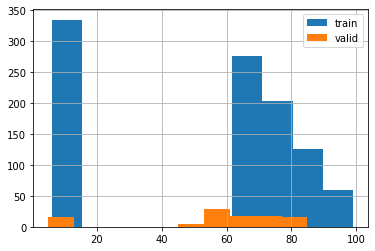

In [23]:
#checking distribution for ages
df_train.age.hist()
df_valid.age.hist()
plt.legend(["train","valid"]);

In [24]:
#should be only 0s and 1s
df_train.gender.unique(), df_valid.gender.unique()

(array([0, 1]), array([1, 0, 3]))

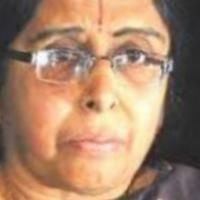

In [25]:
#checking the mislabeled image
open_image(df_valid[df_valid.gender == 3].name.iloc[0])

In [26]:
#fixing the label
idx = df_valid[df_valid.gender == 3].index
df_valid.loc[idx,"gender"] = 1 #1 means woman

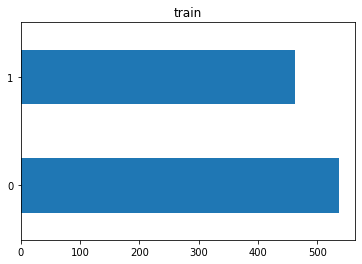

In [27]:
#accuracy is a good metric fore gender
(df_train.gender.value_counts()).plot.barh()
plt.title("train");

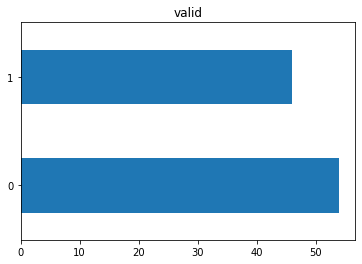

In [28]:
(df_valid.gender.value_counts()).plot.barh()
plt.title("valid");

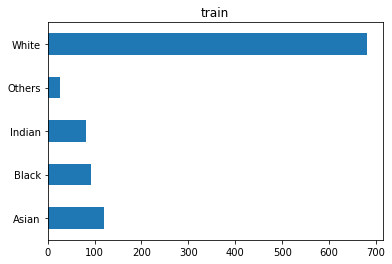

In [29]:
d = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df_train.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("train");

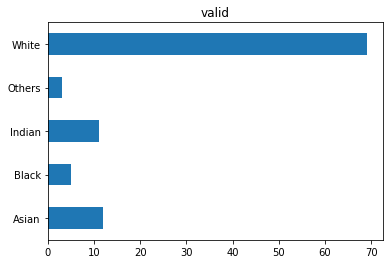

In [30]:
df_valid.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("valid");

# 2. Creating the Datasets, Dataloaders and Databunch

In [31]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [32]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_valid, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
data = DataBunch(train_dl, valid_dl)

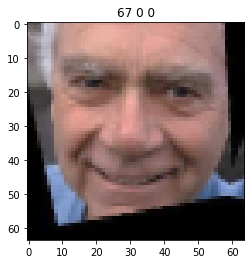

In [33]:
train_ds.show(0)

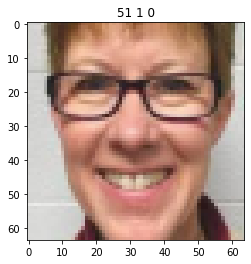

In [34]:
valid_ds.show(0)

In [40]:
class MultiTaskModel(nn.Module):
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024,1,ps=ps)
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return [age, gender, ethnicity]

In [41]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age, gender, ethnicity):

        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages = (age*4.75).exp_()
        idx1 = (sages <20) | ((sages > 40) & (sages <= 60))
        idx2 = sages > 60
        loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2]) #trying to account for the imbalance
        loss1 = crossEntropy(preds[1],gender)
        loss2 = crossEntropy(preds[2],ethnicity)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

# 4. Defining Metrics, Learner and Training

In [42]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [43]:
model = MultiTaskModel(models.resnet18, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

# spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
learn.freeze()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [44]:
from torchsummary import summary
summary(model, input_size=(3,48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [45]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [46]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [ ]:
learn.lr_find()


In [ ]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(1,max_lr=1e-2)

epoch,train_loss,valid_loss,rmse_age,acc_gender,acc_ethnicity,time


RuntimeError: ignored

In [ ]:
learn.load("stage-1");

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=slice(1e-6,3e-4),
                   callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [ ]:
learn = learn.load("stage-2")


# 5. Using the model to inference

In [ ]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_resnet34")

In [ ]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        self.gender = {0:"Male",1:"Female"}
        self.ethnicity = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 64)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        age = int(torch.exp(preds[0]*4.75).item())
        gender = self.gender[torch.softmax(preds[1],1).argmax().item()]
        ethnicity = self.ethnicity[torch.softmax(preds[2],1).argmax().item()]
        return age, gender, ethnicity

In [ ]:
ageneth_predictor = AgenethPredictor(trained_model)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[100])
img

In [ ]:
df_valid.name.iloc[100]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[1000])
img

In [ ]:
df_valid.name.iloc[1000]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[2000])
img

In [ ]:
df_valid.name.iloc[2000]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[50])
img

In [ ]:
df_valid.name.iloc[50]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[9000])
img

In [ ]:
df_valid.name.iloc[9000]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-1])
img

In [ ]:
df_valid.name.iloc[-1]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-100])
img

In [ ]:
df_valid.name.iloc[-100]

In [ ]:
%time ageneth_predictor.predict(img)

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-500])
img

In [ ]:
df_valid.name.iloc[-500]

In [ ]:
%time ageneth_predictor.predict(img)